## Сверточные нейронные сети

Операция свертки (convolution):

![alt text](img/conv-01.gif "Title")

У свертки есть ядро (kernel) - матрица, веса которой ищутся в процессе обучения

![alt text](img/conv-02.gif "Title")
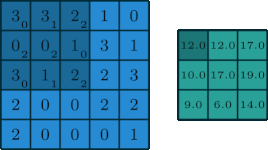

Свертки позволяют находить паттерны (*features*)

![alt text](img/conv-03.jpg "Title")

У свертки есть:
* Размер ядра (kernel_size)
* Размер шага (strides)
* Отступ (padding)

![alt text](img/conv-04.gif "Title")

Светочный слой нейросети [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) состоит из множества сверток (каждая со своим ядром и каждая нацелевается при обучении на свой паттерн)

![alt text](img/conv-05.jpg "Title")

На выходе сверточного слоя получаются карты признаков (*feature maps*). Это огромное количество информации, даже больше чем в исходном изображении.

Поэтому используется техника понижения размерности (*downsampling*) - **pooling**. Разновидности: MaxPooling и AveragePooling

![alt text](img/conv-06.jpg "Title")

Операции свертки и понижения размерности могут производится несколько раз, следуя друг за другом (*feature extraction*)

В конце, информацию необходимо "распрямить", получив обычный вектор (размерности 1хN). Сделать это можно операциями [GlobalAveragePooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) или [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

![alt text](img/conv-07.png "Title")

Такой вектор описывает найденные признаки и называется **embedding**

На финальном этапе, вектор признаков можно подать в качестве входа на стандартную нейросеть классификации (как в ирисах)

![alt text](img/conv-08.jpg "Title")

## Практическая часть

Выбираем для работы GPU 0 и отключаем отладочные сообщения в TensorFlow

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

import numpy as np

Узнай о работе с изображениями в Python и о библиотеках [PIL](https://pillow.readthedocs.io/en/stable/) (*Python Imaging Library*) и [cv2](https://opencv.org/) (*OpenCV*).

Изучи многообразие форматов представления изображений в python (shapes)

(397, 397, 3)


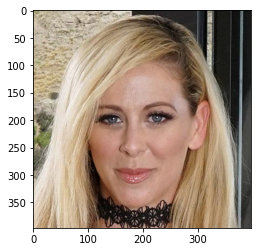

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2

img = Image.open('/opt/ai/datasets/faces/1449_001.jpg')
print(np.asarray(img).shape)
#print(np.asarray(img))

img2 = cv2.imread('/opt/ai/datasets/faces/1449_001.jpg')
img2.shape
img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img3)
plt.show()

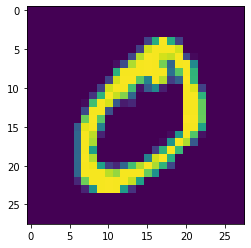

(28, 28)

In [21]:
imgm = cv2.imread('/opt/datasets/MNIST/train/0/1.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(imgm)
plt.show()
imgm.shape

In [24]:
IMG_SIZE = (28, 28)
BATCH_SIZE = 64

Узнай о [DataGenerator](https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c)-ах keras. В частности об [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) и его методах [flow_from_directory()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) и [flow_from_dataframe()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe)

Создай **train_generator** и **val_generator** для датасета [MNIST](https://ru.wikipedia.org/wiki/MNIST_(%D0%B1%D0%B0%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)) (данные находятся в каталогах */opt/datasets/MNIST/train* и */opt/datasets/MNIST/test*)

In [86]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(data_format="channels_last")

gen_args = {
    'target_size': IMG_SIZE,
    'color_mode': 'grayscale',
    'class_mode': 'categorical',
    'batch_size': BATCH_SIZE,
}

train_gen = gen.flow_from_directory(directory='/opt/datasets/MNIST/train', shuffle=True, **gen_args)
val_gen = gen.flow_from_directory(directory='/opt/datasets/MNIST/test', shuffle=False, **gen_args)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


Узнай как из генератора вытаскивать "классы"(категории) и "правильные ответы" при помощи свойств **class_indices** и **classes**. 

In [34]:
print(train_gen.class_indices)
print(list(train_gen.class_indices.keys()))
print(list(train_gen.class_indices.values()))

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [35]:
train_gen.classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [42]:
print(train_gen.next()[0].shape)
print(train_gen.next()[1].shape)

(64, 28, 28, 1)
(64, 10)


Узнай чем плох дизбаланс классов и создай словарь весов классов (*class_weight*) для балансировки обучающих данных. В этом поможет функция [compute_class_weight()](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)

In [52]:
import sklearn.utils
weights = sklearn.utils.class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = list(train_gen.class_indices.values()),
    y = list(train_gen.classes),
)

class_weights = dict(zip(list(train_gen.class_indices.values()), list(weights)))
class_weights

{0: 1.0130001688333614,
 1: 0.8899436369029962,
 2: 1.0070493454179255,
 3: 0.978633175664655,
 4: 1.0270455323519343,
 5: 1.1068068622025458,
 6: 1.013856032443393,
 7: 0.9577015163607342,
 8: 1.025465732353444,
 9: 1.0085728693898135}

Создай модель сверточной нейросети для разпознавания цифр в датасете MNIST и выведи summary() модели

In [64]:
model = tf.keras.Sequential(name = 'Conv')

model.add(tf.keras.layers.InputLayer(input_shape = IMG_SIZE + (1,) ))
model.add(tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.GlobalAveragePooling2D())
#model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "Conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 5)         50        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 5)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 5)         230       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 5)          0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 5)                0         
 (GlobalAveragePooling2D)                                        
                                                              

Скомпилируй модель, выбрав лосс-функцию, оптимизатор и метрики

In [65]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    metrics = ['accuracy'],
)

Натренируй модель и отобрази графики тренировки

In [66]:
res = model.fit(
    x = train_gen,
    batch_size = BATCH_SIZE,
    epochs = 5,
    validation_data = val_gen,
)

Epoch 1/5
938/938 [==============================] - 207s 210ms/step - loss: 3.3059 - accuracy: 0.1518 - val_loss: 2.1764 - val_accuracy: 0.2077
Epoch 2/5
938/938 [==============================] - 16s 17ms/step - loss: 1.9835 - accuracy: 0.2923 - val_loss: 1.5893 - val_accuracy: 0.4348
Epoch 3/5
938/938 [==============================] - 16s 17ms/step - loss: 1.3126 - accuracy: 0.5427 - val_loss: 1.1147 - val_accuracy: 0.6189
Epoch 4/5
938/938 [==============================] - 16s 17ms/step - loss: 1.0886 - accuracy: 0.6245 - val_loss: 0.9956 - val_accuracy: 0.6574
Epoch 5/5
938/938 [==============================] - 16s 17ms/step - loss: 0.9928 - accuracy: 0.6597 - val_loss: 0.9200 - val_accuracy: 0.6877


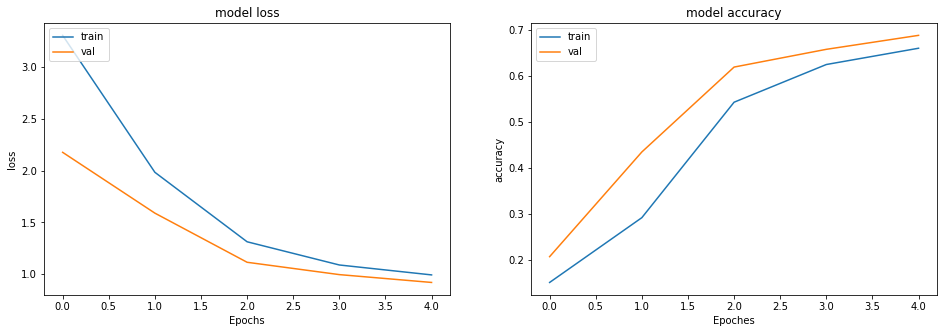

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(121)
ax.plot(res.history['loss'])
ax.plot(res.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('Epochs')
ax.legend(['train', 'val', 'runs'], loc='upper left')

ax = fig.add_subplot(122)
ax.plot(res.history['accuracy'])
ax.plot(res.history['val_accuracy'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoches')
ax.legend(['train', 'val', 'runs'], loc='upper left')

Построй [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) модели на проверочных данных

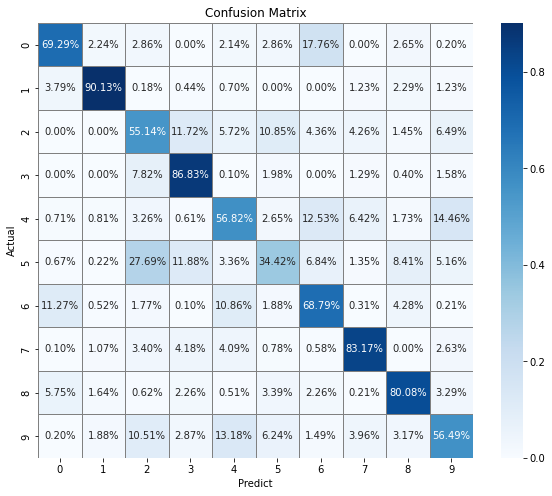

In [89]:
import sklearn.metrics

class_names = list(val_gen.class_indices.values())

y_pred = model.predict(val_gen)

y_val_pred_class = [np.argmax(i) for i in y_pred]
y_val_true_class = list(val_gen.classes)

cm = sklearn.metrics.confusion_matrix(
    y_true = y_val_true_class,
    y_pred = y_val_pred_class,
)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

import seaborn as sns

plt.figure(figsize=(10,8))
ax = sns.heatmap(cmn, annot=True, fmt='.2%', xticklabels=class_names, yticklabels=class_names, cmap='Blues', square=True, linewidths=0.5, linecolor='gray')
ax.set_title('Confusion Matrix');
ax.set_xlabel('Predict')
ax.set_ylabel('Actual');
plt.show()

Напиши код, который читает [эту картинку](https://www.nicepng.com/png/detail/939-9392093_handwritten-5.png) из сети, отображает её, распознает цифру изображенную на ней и выводит ответ

In [130]:
from PIL import Image
import urllib.request

URL = 'https://www.nicepng.com/png/detail/939-9392093_handwritten-5.png'

with urllib.request.urlopen(URL) as url:
    img = Image.open(url)

from PIL import Image, ImageOps
img = ImageOps.grayscale(img)
img = img.resize(IMG_SIZE)
img.show()
print(np.asarray(img).shape)
inverted_img = ImageOps.invert(img)
inverted_img

(28, 28)


In [131]:
data = np.asarray(inverted_img)
data = data[..., np.newaxis]
data.shape

data_pred = model.predict(data[np.newaxis, ...])
data_pred

array([[1.38135118e-04, 5.43684450e-07, 5.12906194e-01, 5.30848242e-02,
        5.10176457e-02, 2.61371464e-01, 7.80192949e-03, 2.60233041e-03,
        3.85343126e-04, 1.10691585e-01]], dtype=float32)

In [132]:
np.argmax(data_pred[0])

2